<a href="https://colab.research.google.com/github/dgallacher1/NotebookProjects/blob/main/Vacuum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phys 659 Assignment 1
Author: David Gallacher

This notebook does vacuum system calculations

In [1]:
#Import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

width = 10
height = 10
matplotlib.rcParams['figure.figsize'] = [width, height]

## Question 

You have a cylindrical vacuum system built of steel with a diameter of 1m and a height of 50 cm. It is connected to a pump with a speed of 80 l/s and ultimate pressure of 1 x 10-6 mbar with a 1 m long CF UHV Flange Thin Wall Metal Vacuum Hose (see [https://www.mksinst.com/f/cf-thin-metal-hose]). (*) Lets assume Hoses of 2.75” diameter cost 500, whereas those of 4.5” cost 2000. If you decide to use the 4.5” hose you will have to include a connecting reduction flange (assume you have one lying around in the lab), as your vacuum system flange is only 2.75” in diameter. Your job is to provide the data to make a decision which hose to buy. The decision will be based on the end pressure achievable (without baking) as well as the pump down times to achieve a particular pressure.  


In [2]:
#Extract some of the parameters as tunable inputs

#Some conversion factors
inch = 2.54 # in to cm
pi = 3.14159
torr = 1.33322 #torr from mbar
mbar = 1.0/torr #Mbar to torr
litre = 0.001 #cm3 to litre
seconds = 3600.0 #hours to seconds 

#Pump parameters
speed_pump = 80 #l/s
outlet_p = 1e-6 #Guess? Not specified anywhere

#Vacuum system dimensions
system_rad = 50 # cm 
system_height = 50 # cm

#Hose dimensions
hose_len = 100 # cm
hose_rad = 2.75/2.0*inch # cm

#Targets
targ_pres = 1e-6 #mbar

#Outgassing rate 
og_rate = 1e-8 #mbar*l/cm2/s

#Start at atmospheric pressure
p_start = 1013.25 #mbar

#Gas properties
T_g = 297.0 #temp in K 
M_g = 28 # Gas AMU (Nitrogen)

In [3]:
#Functions for calculations

#Conductance in l/sec
def conductance(d,l,p1,p2,T,M,flag):
  #d = diameter of tube in cm
  #l = length of tube in cm
  #p1 = inlet pressure, torr
  #p2 = outlet pressure, torr
  #T = temp in K
  #M = atomic mass unit of gas (28 for N2)
  #flag = 0 for viscous flow, 1 for laminar flow

  c = 0.0 #Conductance in l/sec

  if flag == 0:
    c = 1.38e2*(pow(d,4)/l)*0.5*(p1-p2)
  elif flag ==1:
    c = 3.81*(pow(d,3)/l)*np.sqrt(T/M)
  else:
    print("Invalid flag setting!, flag = 0 for viscous, or = 1 for laminar flow")

  return c

#effective speed
def effective_speed(s,p):
  #Find the effective pump speed based on conductance at pressure p

  #Turbulent flow
  if p > 1e-6:
    c = conductance(hose_rad*2,hose_len,p*torr,outlet_p*torr,T_g,M_g,0)
    s_eff = s*c/(s+c)
    return s_eff
  #Molecular flow
  else:
    c = conductance(hose_rad*2,hose_len,p*torr,outlet_p*torr,T_g,M_g,1)
    s_eff = s*c/(s+c)
    return s_eff

#Throughput Q (mbar l/s)
def throughput(p,s):
  q = p*effective_speed(s,p)
  return q

#volume of a cylinder, pretty straight forward
def volume_cyl(r,h):
  return pi*r*r*h

#Surface area of cylinder
def sa_cyl(r,h):
  return 2*pi*r*h+2*pi*r*r

#Add some outgassing to whatever pressure we had before
def outgassing(p,t,v,sa,rate):
  #rate = mbar*l/cm2/s
  #Naive outgassing where we outgas a single species and don't check the pressure for vapour pressure vs species
  p_og = rate*sa*t/v
  return p_og


In [4]:
#Define master function to call others

#Takes in 1-D np.array() each for pressure and time
def pump_down(p,t,v):
  #Step through time array calculating pumping for each cumulative time step
  t_last = 0.0
  for index, t_step in enumerate(t):
    if index == 0:
      continue #Skip first step 
    p_step = p[index-1] #pressure at the previous time-step
    q_step = throughput(speed_pump,p_step) #Throughput for this time-step
    #print("q = {}".format(q_step))
    t_diff = (t_step-t_last) #Duration of this time-step in seconds (time in hours)
    p_drop = q_step/(v*litre)*t_diff  #pressure drop from pumping for this time interval
    #print("p_drop = {}".format(p_drop))
    t_last = t_step #Time-differences only
    p[index] = p_step-p_drop #update pressure array
  return p

In [5]:
#Lets plot some things

#Initialize time array
max_time = 20000 #seconds
time = np.linspace(num=max_time*2,start=0,stop=max_time)

#First find the volume of our vacuum system in cm3
vol = volume_cyl(system_rad,system_height) + volume_cyl(hose_rad,hose_len) #Volume includes hose and vacuum system
print("Volume of system to pump is = {:.3} litre".format(vol*litre))

surf_area = sa_cyl(system_rad,system_height) + sa_cyl(hose_rad,hose_len) #surface area of system including hose
print("surface area of system to pump is = {:.3} cm2".format(surf_area))

pressure = np.full_like(time,p_start) #Initialize pressure data to whatever we intiialized time to

Volume of system to pump is = 3.97e+02 litre
surface area of system to pump is = 3.37e+04 cm2


### a) Plot the pressure vs. time for the situation where you only include the gas volume (thus neglecting out gassing etc. from chamber walls).

Here we will plot the pressure vs time by assuming we started at atmospheric pressure inside the defined volume with the above parameters

In [6]:
#Calculate pressure vs time
pressure = pump_down(pressure,time,vol)

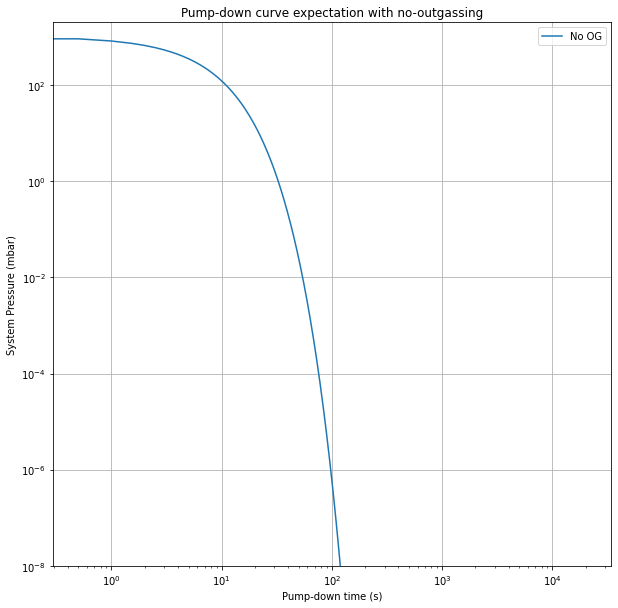

In [7]:
#Plot pressure versus time
fig,ax = plt.subplots()
plt.plot(time,pressure,label='No OG',axes=ax)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('System Pressure (mbar)')
plt.xlabel('Pump-down time (s)')
plt.ylim(1e-8,2e3)
plt.title("Pump-down curve expectation with no-outgassing")
plt.grid()
ax.legend()

##e)	Plot (on the same graph) the pump down times assuming an outgas rate of the used vacuum system wall material of  10-8 mbar l  cm-2s-1 (typical value for steel).

In [8]:
#Modify the plot function to add outgassing
def pump_down_og(p,t,v,rate):
  #Step through time array calculating pumping for each cumulative time step
  t_last = 0.0
  for index, t_step in enumerate(t):
    if index == 0:
      continue #Skip first step 
    p_step = p[index-1] #pressure at the previous time-step
    q_step = throughput(speed_pump,p_step) #Throughput for this time-step
    t_diff = (t_step-t_last) #Duration of this time-step in seconds (time in hours)
    p_drop = q_step/(v*litre)*t_diff  #pressure drop from pumping for this time interval
    p_og = outgassing(p_step,t_diff,v*litre,surf_area,rate) #add outgassing 
    t_last = t_step #Time-differences only
    p[index] = p_step-p_drop+p_og #update pressure array
  return p

In [9]:
# calculate pumpdown curve with outgassing
pressure_og = np.full_like(time,p_start)
pressure_og = pump_down_og(pressure_og,time,vol,og_rate)

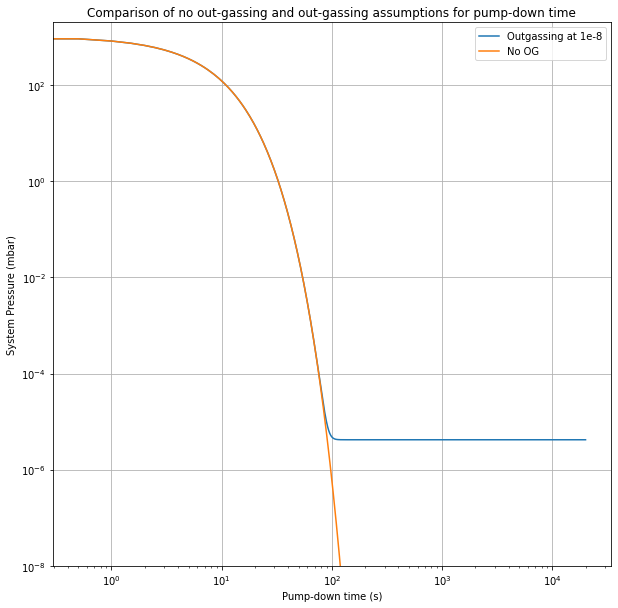

In [10]:
#plot with outgassing overlaid
fig,ax = plt.subplots()
plt.plot(time,pressure_og,label="Outgassing at 1e-8")
plt.plot(time,pressure,label='No OG',axes=ax)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('System Pressure (mbar)')
plt.xlabel('Pump-down time (s)')
plt.ylim(1e-8,2e3)
plt.title("Comparison of no out-gassing and out-gassing assumptions for pump-down time")
plt.grid()
ax.legend()

Comparing the two plots, we can see when we consider the effect of outgassing from the vessel, we have a smaller acheivable pressure with this pumping configuration

### f)	Having made the choice of either the 4” or 5” hose a year ago, you now want to achieve a pressure of 2 x 10-6 mbar from atmospheric pressure in a time of 3 minutes. What pump speed do you require of pumps having an ultimate pressure of 1 x 10-7 mbar? Can you find such pumps in catalogues? (note - you can connect more than one pumping line to the system – but that need more pump lines etc.) 

---

Let's plot the time to 2x10-6 for a 5" hose versus specified pump speed


In [11]:
#Start by redefining the hose rad 
hose_rad = 5/2.0*inch #5 inch diameter
target_pressure = 2e-6 #mbar target
pump_speeds = np.linspace(10,200,50) #Initialize array for pump speed scan
time_to_target = np.empty_like(pump_speeds)#initialize same shaped array for time to reach target pressures

In [12]:
#Define functions to scan over pump_speeds

#Pump-down function from initial p to final p, and pump speed, returns time to target
def pump_down_differential(p_init,p_targ,v,s):
  #Step through time array calculating pumping for each cumulative time step
  p_last = p_init #initialize to starting pressure
  t_step = 1 # time step size in seconds
  t_total = 0.0 #Cumulative time
  while p_last > p_targ:
    q_step = throughput(s,p_last) #Throughput for this time-step
    p_drop = q_step/(v*litre)*t_step  #pressure drop from pumping for this time interval
    #p_og = outgassing(p_last,t_step,v*litre,surf_area,rate) #add outgassing 
    p_last = p_last-p_drop#+p_og #update pressure array
    t_total += t_step #Add time step 
  return t_total

#Takes in the pump speeds for setting and time to target pressure to be updated
def scan_pump_speeds(speeds,times):
  #We're using globals everywhere so we can just update those to scan
  for index,s in enumerate(speeds):
    t_to_target = pump_down_differential(p_start,target_pressure,vol,s) #Calculate time to target for each pump speed assuming outgassing
    times[index] = t_to_target #update time array
    #print("time to target for speed {} = {}".format(s,t_to_target))
  return None

In [13]:
#Call the functions to update time array
#First re-initialize volume with new hose dimensions
vol = volume_cyl(system_rad,system_height) + volume_cyl(hose_rad,hose_len) #Volume includes hose and vacuum system
scan_pump_speeds(pump_speeds,time_to_target)

The spec pump speed required to reach 2e-6 mbar in 3 minutes is = 42.8 (l/s)


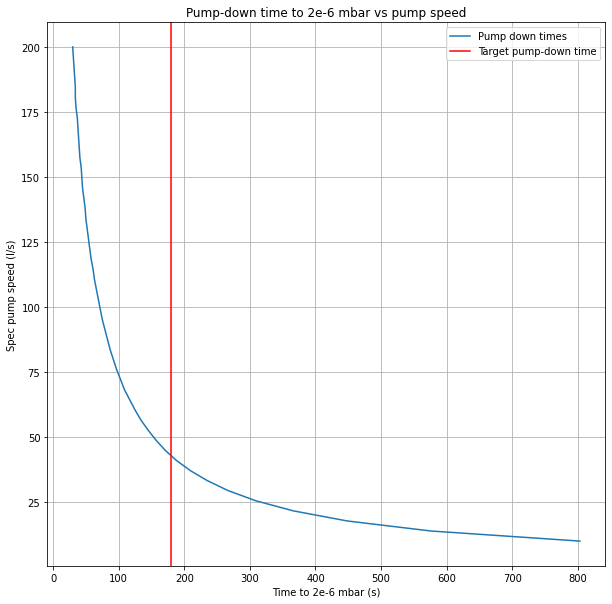

In [14]:
#Plot pump speed versus time to target
fig_s,ax_s = plt.subplots()
plt.plot(time_to_target,pump_speeds,axes=ax_s,label='Pump down times')
plt.title("Pump-down time to 2e-6 mbar vs pump speed")
plt.ylabel('Spec pump speed (l/s)')
plt.xlabel('Time to 2e-6 mbar (s)')
plt.grid()

#overlay another line showing the target time to 2e-6
t_target = 180.0 #s
plt.axvline(x = t_target,color='red', label = 'Target pump-down time')
plt.legend()

#Interpolate for target time
from scipy import interpolate
f_speed = interpolate.interp1d(time_to_target,pump_speeds)
print("The spec pump speed required to reach 2e-6 mbar in 3 minutes is = {:3.3} (l/s)".format(f_speed(t_target)))

The spec pump speed required to reach 1e-7 mbar in 3 minutes is = 48.8 (l/s)


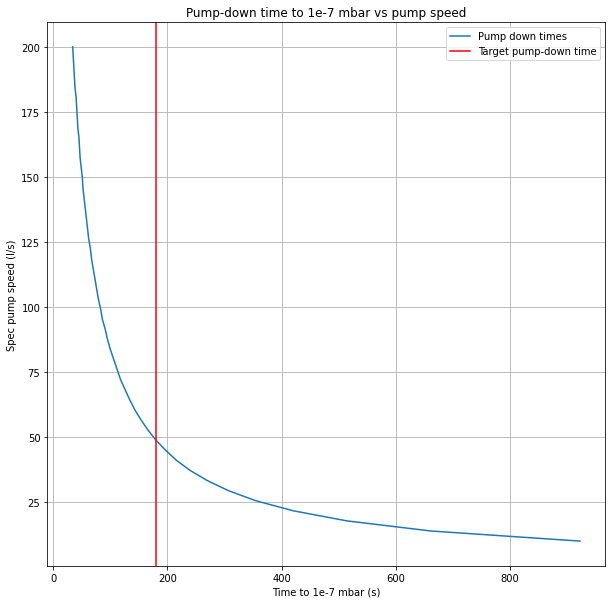

In [15]:
#Repeat above but for 1e-7 target
target_pressure=1e-7
scan_pump_speeds(pump_speeds,time_to_target)

#Plot pump speed versus time to target
fig_s,ax_s = plt.subplots()
plt.plot(time_to_target,pump_speeds,axes=ax_s,label='Pump down times')
plt.title("Pump-down time to 1e-7 mbar vs pump speed")
plt.ylabel('Spec pump speed (l/s)')
plt.xlabel('Time to 1e-7 mbar (s)')
plt.grid()

#overlay another line showing the target time to 2e-6
t_target = 180.0 #s
plt.axvline(x = t_target,color='red', label = 'Target pump-down time')
plt.legend()

#Interpolate for target time
from scipy import interpolate
f_speed = interpolate.interp1d(time_to_target,pump_speeds)
print("The spec pump speed required to reach 1e-7 mbar in 3 minutes is = {:3.3} (l/s)".format(f_speed(t_target)))

So assuming we have no out-gassing, with a 5" hose attached we can reach the target pressure of 2e-6 mbar with a ~42 l/s pump

If we're targetting 1e-7 in 3 minutes, we need a ~49 l/s pump. 

As shown before, with outgassing included neither of these are true because we plateau well above (1e-4) the target pressures and never reach, we could use a two-stage pumping system to get to the targets for a realistic system.

## Effective pump speed

Just out of curiosity let's check how does the effective pump speed change versus the inlet pressure when we're doing the differential conductance tests

Text(0.5, 0, 'Inlet pressure (mbar)')

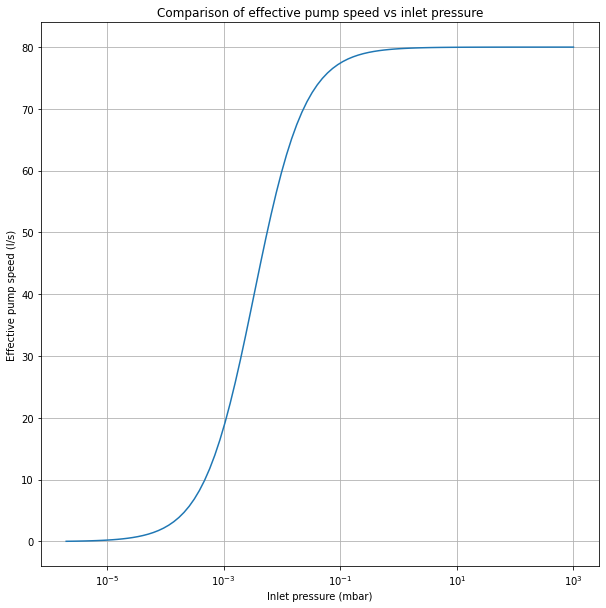

In [16]:
#Plot effective pump speed versus pressure
pressure_test = np.geomspace(2e-6,1000,100) #Logarithmically distributed pressured between 2e-6 and 1000 mbar
eff_speeds = np.empty_like(pressure_test)

for index, p in enumerate(pressure_test):
  eff_speeds[index] = effective_speed(speed_pump,p)

plt.plot(pressure_test,eff_speeds)
plt.xscale('log')
plt.title("Comparison of effective pump speed vs inlet pressure")
plt.ylabel('Effective pump speed (l/s)')
plt.grid()
plt.xlabel('Inlet pressure (mbar)')